In [1]:
from casacore.tables import table
from matplotlib.colors import LogNorm
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np
%matplotlib inline

### Define path and load MS table

In [2]:
# pre-flagged MS file
#MSfile = '1375091767.full_pol_av.ms'
MSfile = '1354773022.full_pol_av.ms'
MSfileFlagged = 'flagged/'+MSfile

In [3]:
# open MS file
t = table(MSfile)
tflag = table(MSfileFlagged)
print('\nMS: ', MSfile, '\n')

# print MS columns
print('MS tables: ', t.colnames(), '\n')
print('Flagged MS tables: ', tflag.colnames(), '\n')

Successful readonly open of default-locked table 1354773022.full_pol_av.ms: 25 columns, 48015 rows
Successful readonly open of default-locked table flagged/1354773022.full_pol_av.ms: 25 columns, 48015 rows
('\nMS: ', '1354773022.full_pol_av.ms', '\n')
('MS tables: ', ['UVW', 'FLAG', 'FLAG_CATEGORY', 'WEIGHT', 'SIGMA', 'ANTENNA1', 'ANTENNA2', 'ARRAY_ID', 'DATA_DESC_ID', 'EXPOSURE', 'FEED1', 'FEED2', 'FIELD_ID', 'FLAG_ROW', 'INTERVAL', 'OBSERVATION_ID', 'PROCESSOR_ID', 'SCAN_NUMBER', 'STATE_ID', 'TIME', 'TIME_CENTROID', 'DATA', 'WEIGHT_SPECTRUM', 'MODEL_DATA', 'CORRECTED_DATA'], '\n')
('Flagged MS tables: ', ['UVW', 'FLAG', 'FLAG_CATEGORY', 'WEIGHT', 'SIGMA', 'ANTENNA1', 'ANTENNA2', 'ARRAY_ID', 'DATA_DESC_ID', 'EXPOSURE', 'FEED1', 'FEED2', 'FIELD_ID', 'FLAG_ROW', 'INTERVAL', 'OBSERVATION_ID', 'PROCESSOR_ID', 'SCAN_NUMBER', 'STATE_ID', 'TIME', 'TIME_CENTROID', 'DATA', 'WEIGHT_SPECTRUM', 'MODEL_DATA', 'CORRECTED_DATA'], '\n')


### Get columns of interest

In [4]:
# get the list of antennas for each entry in the main table
A1 = t.getcol("ANTENNA1")
A2 = t.getcol("ANTENNA2")

# get the scan numbers for each entry in the main tables
scans = t.getcol("SCAN_NUMBER")

# get flag column from main table
flags = t.getcol("FLAG")
AOflags = tflag.getcol("FLAG")

# get data column from main table
data = t.getcol("DATA")
AOdata = tflag.getcol("DATA")

# get the time column from the main table
time = t.getcol("TIME")

#plt.plot(A2[0:10000])
#x=set(np.append(A1,A2))
print(flags.shape, t.getcol("FLAG_CATEGORY").shape)

((48015, 601, 4), (48015, 1, 601, 4))


In [5]:
#view shapes
print('Data shape: ', data.shape, '\n')
print('AOflags shape: ', AOflags.shape, '\n')

# note data types:
print('FLAG type: ', flags.dtype)
print('AOFLAG type: ', AOflags.dtype)
print('DATA type: ', data.dtype, '\n')

#get other important stats
print('Number of timestamps:    ', data.shape[0])        
print('Number of channels:      ', data.shape[1])
print('Number of polarisations: ', data.shape[2], '\n')

('Data shape: ', (48015, 601, 4), '\n')
('AOflags shape: ', (48015, 601, 4), '\n')
('FLAG type: ', dtype('bool'))
('AOFLAG type: ', dtype('bool'))
('DATA type: ', dtype('complex64'), '\n')
('Number of timestamps:    ', 48015)
('Number of channels:      ', 601)
('Number of polarisations: ', 4, '\n')


### Get baselines

In [6]:
# extract uvw  coordinates from the main table
uvw = t.getcol("UVW")
u,v,w = uvw[:,0],uvw[:,1],uvw[:,2]

In [7]:
ant_list = list(set(np.append(A1,A2)))
nants = len(ant_list)

ant1_map = []
ant2_map = []
for a1 in ant_list:
    for a2 in ant_list[a1+1:]:
        ant1_map.append(a1)
        ant2_map.append(a2)
        
        
nchans = data.shape[1]
nbase = nants*(nants-1)/2

print('Number of antennas:  ', nants)
print('List of antennas:    ', ant_list)
print('Number of baselines: ', nbase)
print()

('Number of antennas:  ', 6)
('List of antennas:    ', [0, 1, 2, 3, 4, 5])
('Number of baselines: ', 15)
()


### Based on flags, get data and mask

In [8]:
# extract data from desired baseline and poln for plotting:
#    data[(A1==ant1) & (A2==ant2)]                 --> selects data where A1 == ant1 and A2 == ant2
#    data[(A1==ant1) & (A2==ant2)][:,:,poln]       --> slices out all times, all channels, polarisation poln
#    abs(data[(A1==ant1) & (A2==ant2)][:,:,poln])  --> takes absolute value of complex data for plotting
        

# plot baseline 1-2, polarisation 0
ant1 = 4
ant2 = 5
poln = 1

#using hand flagged mask
data_a = abs(data[(A1==ant1) & (A2==ant2)][:,:,poln])
flag_mask = np.array(flags[(A1==ant1) & (A2==ant2)][:,:,poln])

#using AOFlagger mask
AOdata_a = abs(data[(A1==ant1) & (A2==ant2)][:,:,poln])
AOflag_mask = np.array(AOflags[(A1==ant1) & (A2==ant2)][:,:,poln])

# mask flagged points
masked_data = np.ma.array(data_a, mask=flag_mask)
AOmasked_data = np.ma.array(data_a, mask=AOflag_mask)

# transpose to plot
data_a = data_a.transpose()
masked_data = masked_data.transpose()
#
AOdata_a = AOdata_a.transpose()
AOmasked_data = AOmasked_data.transpose()

#get basic stats about data
mean_amp = np.average(data_a)
min_amp = np.min(data_a)

AOmean_amp = np.average(AOdata_a)
AOmin_amp = np.min(AOdata_a)

print('Mean v, AOv: ', mean_amp, AOmean_amp)
print('Min v, AOv:  ', min_amp, AOmin_amp)

('Mean v, AOv: ', 0.0055900253, 0.0055900253)
('Min v, AOv:  ', 0.0, 0.0)


#### Show Time-Frequency plot

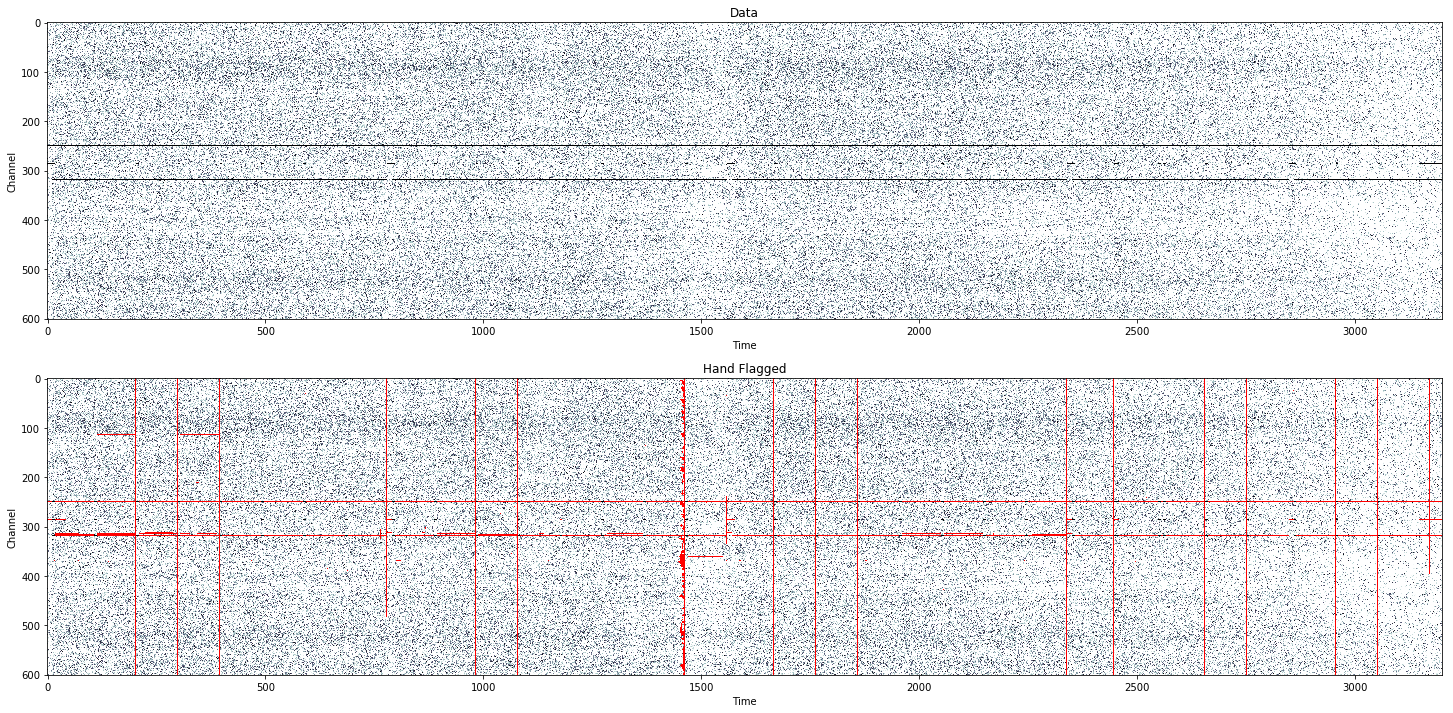

In [10]:
#--------- Hand Flagged data and mask ---

# Set up a colormap
palette = plt.cm.bone
# set masked values to plot red
palette.set_bad('r', 1.0)


# create figure of specified size
fig = plt.figure(figsize=(25,12))

# plot data in top panel
ax1 = fig.add_subplot(211)
im = ax1.imshow(data_a, cmap=palette, vmax=0.7*mean_amp, vmin=1.3*min_amp, aspect='auto')
ax1.set_xlabel('Time')
ax1.set_ylabel('Channel')
ax1.set_title('Data')

# plot data with mask in bottom panel
ax2 = fig.add_subplot(212)
im = ax2.imshow(masked_data, cmap=palette, vmax=0.7*mean_amp, vmin=1.3*min_amp, aspect='auto')
ax2.set_xlabel('Time')
ax2.set_ylabel('Channel')
ax2.set_title('Hand Flagged')

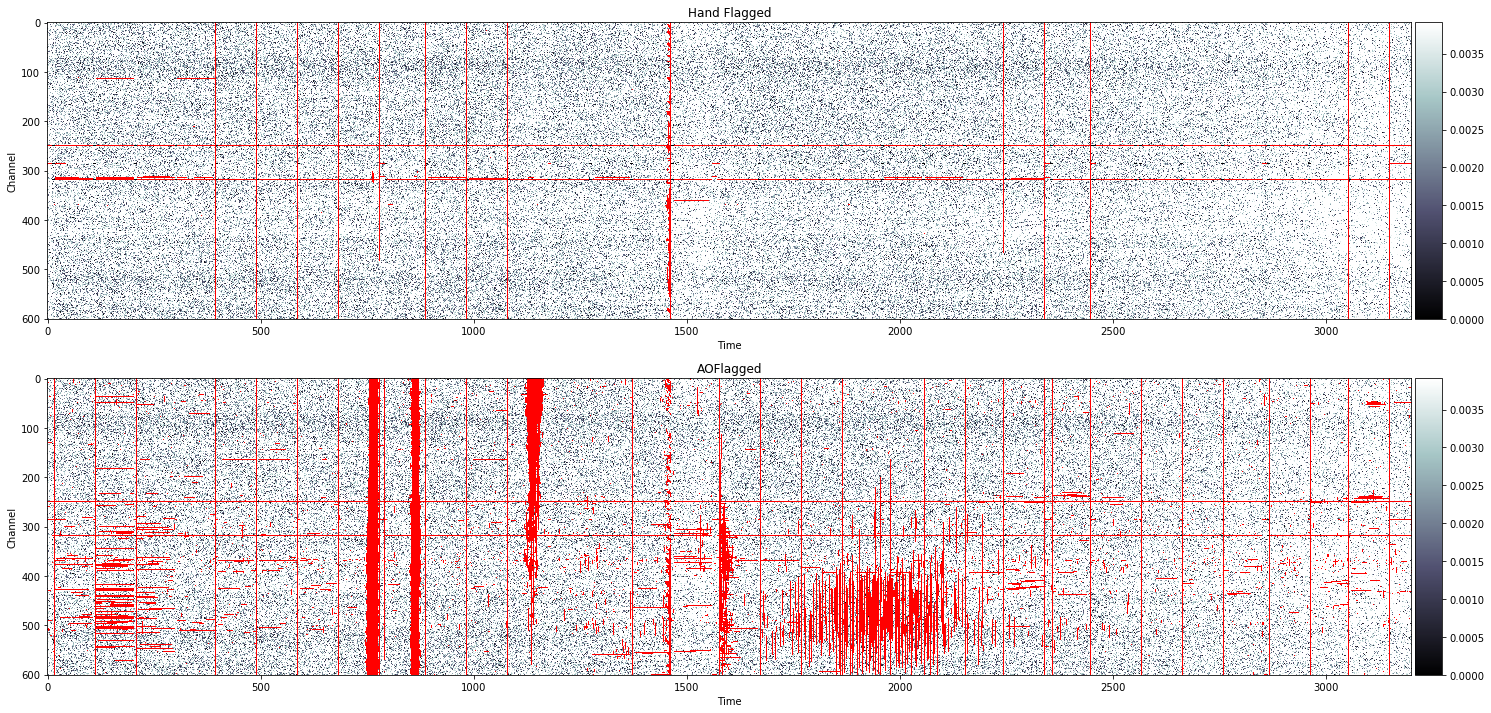

In [11]:
#----- AOFlagged data and Mask ------

# create figure of specified size
fig = plt.figure(figsize=(25,12))

# plot data in top panel
ax1 = fig.add_subplot(211)
im = ax1.imshow(masked_data, cmap=palette, vmax=0.7*AOmean_amp, vmin=1.3*AOmin_amp, aspect='auto')
ax1.set_xlabel('Time')
ax1.set_ylabel('Channel')
ax1.set_title('Hand Flagged')

divider = make_axes_locatable(ax1)
cax = divider.append_axes("right", size="2%", pad=0.05)
cbar = plt.colorbar(im, cax=cax)

# plot data with mask in bottom panel
ax2 = fig.add_subplot(212)
im = ax2.imshow(AOmasked_data, cmap=palette, vmax=0.7*AOmean_amp, vmin=1.3*AOmin_amp, aspect='auto')
ax2.set_xlabel('Time')
ax2.set_ylabel('Channel')
ax2.set_title('AOFlagged')

divider = make_axes_locatable(ax2)
cax = divider.append_axes("right", size="2%", pad=0.05)
cbar = plt.colorbar(im, cax=cax)

In [12]:
#----- log plot AOFlagged data and Mask ------

# Set up a colormap
palette = plt.cm.bone
# set masked values to plot red
palette.set_bad('r', 1.0)


# create figure of specified size
fig = plt.figure(figsize=(25,12))

# plot data in top panel
ax1 = fig.add_subplot(211)
im = ax1.imshow(np.log(masked_data+1e-7), cmap=palette, aspect='auto', vmax=-3, vmin=-6) 
#, vmax=0.7*mean_amp, vmin=np.log10(1.3*min_amp)
ax1.set_xlabel('Time')
ax1.set_ylabel('Channel')
ax1.set_title('Log Hand Flagged')

divider = make_axes_locatable(ax1)
cax = divider.append_axes("right", size="2%", pad=0.05)
cbar = plt.colorbar(im, cax=cax)
        
        
# plot data with mask in bottom panel
ax2 = fig.add_subplot(212)
im = ax2.imshow(np.log(AOmasked_data+1e-7), cmap=palette, aspect='auto', vmax=-3, vmin=-6) #, np.log10(1.3*AOmin_amp)
ax2.set_xlabel('Time')
ax2.set_ylabel('Channel')
ax2.set_title('Log AOFlagged')

divider = make_axes_locatable(ax2)
cax = divider.append_axes("right", size="2%", pad=0.05)
cbar = plt.colorbar(im, cax=cax)

/Users/yabebal/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in log
  
/Users/yabebal/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: divide by zero encountered in log
IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.
